[바나나 분류]

In [3]:
import cv2
import numpy as np
import os
import zipfile

In [4]:
ZIP = '../data/archive.zip'
FOLDER = '../data/dataset2/'

[2] 사용자 정의 함수

In [5]:
# 압축 해제
with zipfile.ZipFile(ZIP, 'r') as zip_ref:
	zip_ref.extractall(FOLDER)

In [6]:
# 압축 해제된 폴더 확인 1
FOLDER2 = '../data/dataset2/'
extracted_files = os.listdir(FOLDER2)
extracted_files

['apple', 'banana', 'grapes', 'orange', 'strawberry']

In [7]:
# 압축 해제된 폴더 확인 2
FOLDER3 = '../data/dataset2/banana/'
extracted_files1 = os.listdir(FOLDER3)
extracted_files1

['Banana_1.jpg',
 'Banana_10.jpg',
 'Banana_100.jpeg',
 'Banana_1000.jpg',
 'Banana_1001.jpg',
 'Banana_1002.jpg',
 'Banana_1003.jpg',
 'Banana_1004.jpg',
 'Banana_1005.jpg',
 'Banana_1006.jpg',
 'Banana_1007.jpg',
 'Banana_1008.jpg',
 'Banana_1009.jpg',
 'Banana_101.jpg',
 'Banana_1010.jpg',
 'Banana_1011.jpg',
 'Banana_1012.jpg',
 'Banana_1013.jpg',
 'Banana_1014.jpg',
 'Banana_1015.jpg',
 'Banana_1016.jpg',
 'Banana_1017.jpg',
 'Banana_1018.jpg',
 'Banana_1019.jpg',
 'Banana_102.jpg',
 'Banana_1020.jpg',
 'Banana_1021.jpg',
 'Banana_1022.jpg',
 'Banana_1023.jpg',
 'Banana_1024.jpg',
 'Banana_1025.jpg',
 'Banana_1026.jpg',
 'Banana_1027.jpg',
 'Banana_1028.jpg',
 'Banana_1029.jpg',
 'Banana_103.jpg',
 'Banana_1030.jpg',
 'Banana_1031.jpg',
 'Banana_1032.jpg',
 'Banana_1033.jpg',
 'Banana_1034.jpg',
 'Banana_1035.jpg',
 'Banana_1036.jpg',
 'Banana_1037.jpg',
 'Banana_1038.jpg',
 'Banana_1039.jpg',
 'Banana_104.jpg',
 'Banana_1040.jpg',
 'Banana_1041.jpg',
 'Banana_1042.jpg',
 'Banana_

In [8]:
import cv2
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 폴더 경로 설정
banana_folders = [
    '../data/dataset2/banana/',
    '../data/dataset2/unripe/',
    '../data/dataset2/overripe/',
]

non_banana_folders = [
    '../data/dataset2/bananakick/',
    '../data/dataset2/bananakick2/',
    '../data/dataset2/mango/',
    '../data/dataset2/chickoo/',
    '../data/dataset2/grapes/',
    '../data/dataset2/lemon/',
]

# 이미지 회전 함수
def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, matrix, (w, h))

# 컬러 기반 특징 추출 함수 (RGB 히스토그램 + 통계)
def extract_color_features(image):
    image = cv2.resize(image, (120, 120))
    chans = cv2.split(image)  # B, G, R 채널 분리
    features = []

    for chan in chans:
        hist = cv2.calcHist([chan], [0], None, [64], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        mean = chan.mean()
        std = chan.std()
        features.extend(hist)
        features.extend([mean, std])
    
    return np.array(features)

# 데이터 수집 및 증강 함수
def collect_data(folder_list, label):
    features = []
    for folder in folder_list:
        if not os.path.exists(folder):
            continue
        for file in os.listdir(folder):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                path = os.path.join(folder, file)
                img = cv2.imread(path)
                if img is None:
                    continue

                # 이미지 증강 (컬러 유지)
                transforms = [
                    img,
                    cv2.flip(img, 1),                 # 좌우 반전
                    rotate_image(img, 15),            # +15도
                    rotate_image(img, -15),           # -15도
                    rotate_image(img, 90),            # 90도 회전
                    rotate_image(img, 180),           # 180도 회전 
                    rotate_image(img, 270),           # 270도 회전 
                ]

                for transformed in transforms:
                    feat = extract_color_features(transformed)
                    row = list(feat) + [label]
                    features.append(row)
    return features

# 바나나/비바나나 데이터 수집
banana_data = collect_data(banana_folders, label=1)
non_banana_data = collect_data(non_banana_folders, label=0)

# 데이터 통합 및 학습 준비
all_data = banana_data + non_banana_data
data = np.array(all_data)
X = data[:, :-1].astype(np.float32)
y = data[:, -1].astype(np.int32)

In [9]:
import pandas as pd

In [10]:
# X, y를 DataFrame으로 변환
df = pd.DataFrame(X)
df['label'] = y  # 마지막 열에 label 추가

In [22]:
# CSV 파일로 저장
csv_path = 'banana1.csv'
df.to_csv(csv_path, index=False)

머신러닝 모델 학습 & 비교

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, log_loss
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

In [13]:
# 학습용 / 테스트용 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [14]:
# 사용할 모델들 정의
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "SVM (RBF)": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

In [15]:
X = df.drop('label', axis=1)
y = df['label']
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  
)

In [16]:
results = []

# 모델별 학습 및 평가
for name, model in models.items():
    try:
        print(f"\n🔍 모델 학습 중: {name}")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_train)

        # 확률 예측이 가능한 모델인지 확인
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_train)
        else:
            y_proba = None

        acc = accuracy_score(y_train, y_pred)
        prec = precision_score(y_train, y_pred, zero_division=0)
        rec = recall_score(y_train, y_pred, zero_division=0)
        f1 = f1_score(y_train, y_pred, zero_division=0)
        ll = log_loss(y_train, y_proba) if y_proba is not None else None

        results.append({
            "Model": name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1 Score": f1,
            "Log Loss": ll
        })

    except Exception as e:
        print(f"⚠️ {name} 모델에서 오류 발생: {e}")


🔍 모델 학습 중: Logistic Regression

🔍 모델 학습 중: Decision Tree

🔍 모델 학습 중: Random Forest

🔍 모델 학습 중: Gradient Boosting

🔍 모델 학습 중: XGBoost

🔍 모델 학습 중: SVM (RBF)

🔍 모델 학습 중: KNN

🔍 모델 학습 중: Naive Bayes


In [23]:
# 결과 출력
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by="F1 Score", ascending=False)
print("모델별 성능 비교:")
df_results.reset_index(drop=True)

모델별 성능 비교:


,Model,Accuracy,Precision,Recall,F1 Score,Log Loss
0,Decision Tree,1.000000,1.000000,1.000000,1.000000,2.220446e-16
1,Random Forest,1.000000,1.000000,1.000000,1.000000,3.660615e-02
2,XGBoost,1.000000,1.000000,1.000000,1.000000,1.283795e-02
3,KNN,0.960074,0.959513,0.962152,0.960831,8.164688e-02
4,Gradient Boosting,0.909060,0.931752,0.886236,0.908424,2.689159e-01
5,SVM (RBF),0.815489,0.826680,0.806579,0.816506,4.652467e-01
6,Logistic Regression,0.815153,0.831046,0.799318,0.814873,4.457665e-01
7,Naive Bayes,0.653153,0.636082,0.744416,0.685998,7.489093e+00


In [18]:
import matplotlib.pyplot as plt
import pandas as pd

In [19]:
df_results = pd.DataFrame({
    'Model': [
        'Decision Tree', 'Random Forest', 'XGBoost', 'KNN',
        'Gradient Boosting', 'Logistic Regression', 'SVM (RBF)', 'Naive Bayes'
    ],
    'Accuracy': [
        1.000000, 1.000000, 0.999869, 0.970903,
        0.920302, 0.838576, 0.805093, 0.706379
    ],
    'Precision': [
        1.000000, 1.000000, 1.000000, 0.962673,
        0.922697, 0.821181, 0.783699, 0.637519
    ],
    'Recall': [
        1.000000, 1.000000, 0.999705, 0.972118,
        0.895405, 0.813307, 0.774508, 0.784097
    ],
    'F1 Score': [
        1.000000, 1.000000, 0.999852, 0.967373,
        0.908846, 0.817225, 0.779076, 0.703252
    ],
    'Log Loss': [
        2.220446e-16, 2.663194e-02, 1.175569e-02, 5.897833e-02,
        2.341395e-01, 3.886053e-01, 4.546055e-01, 7.566759e+00
    ]
})


In [20]:
# 사용할 지표 목록
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Log Loss']

전체적으로 XG Boost가 가장 우수함

[성능 평가]

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# XGBoost 모델 학습
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# 예측 수행
y_pred = xgb_model.predict(X_train)
y_proba = xgb_model.predict_proba(X_train)

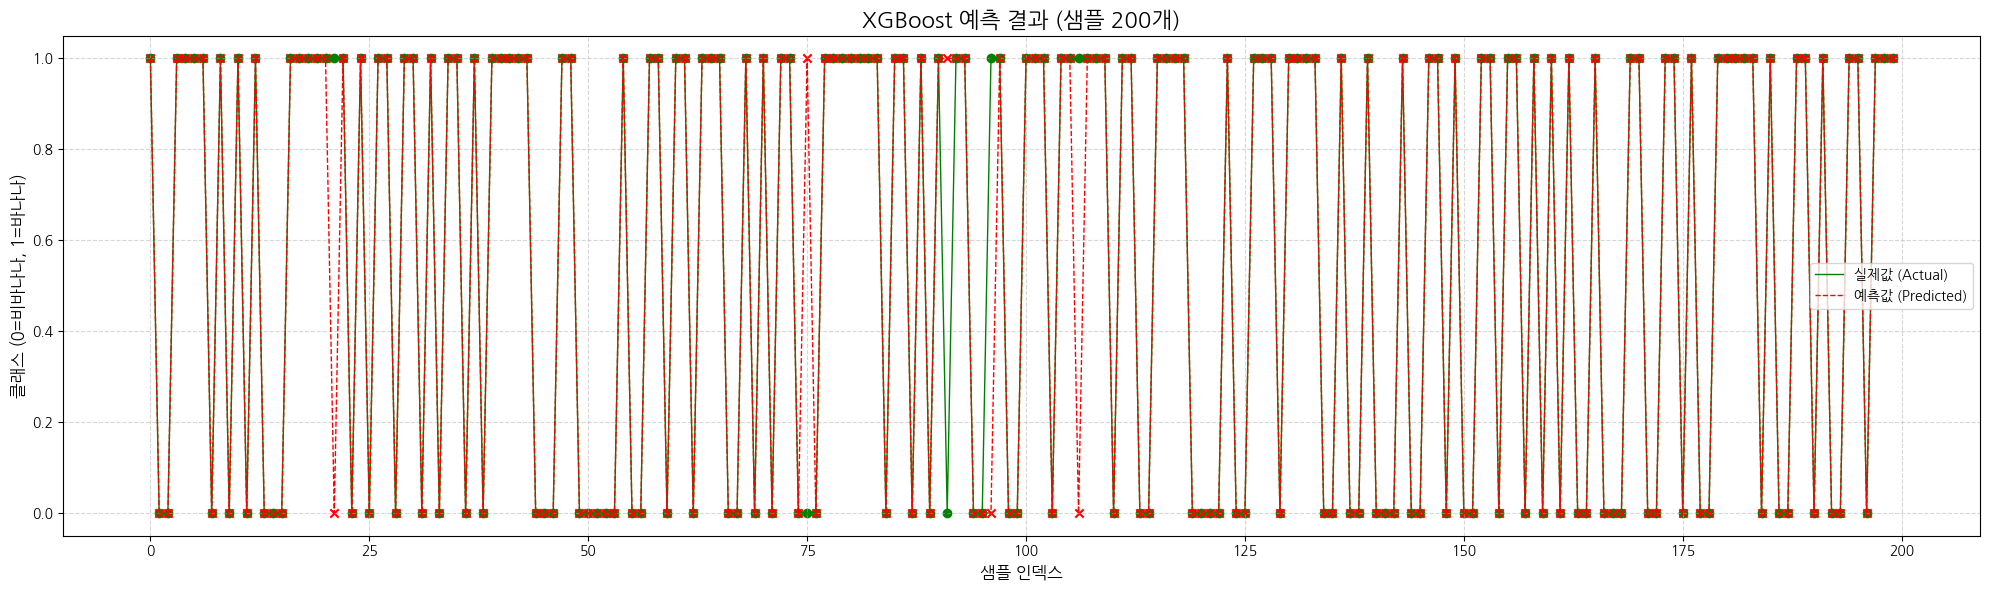

In [46]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import koreanize_matplotlib

# ✅ 1. 모델 학습
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# ✅ 2. 테스트 데이터에 대해 예측
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)

# ✅ 3. 200개 샘플 무작위 추출
np.random.seed(42)
sample_indices = np.random.choice(len(X_test), size=200, replace=False)

sample_true = y_test.reset_index(drop=True).iloc[sample_indices]
sample_pred = pd.Series(y_pred).reset_index(drop=True).iloc[sample_indices]

# ✅ 4. 시각화를 위한 DataFrame 생성
df_sample = pd.DataFrame({
    'Index': range(200),
    'Actual': sample_true,
    'Predicted': sample_pred
})

# ✅ 5. 시각화 (선 + 점)
plt.figure(figsize=(20, 6))

# 선 그래프 추가
plt.plot(df_sample['Index'], df_sample['Actual'], label='실제값 (Actual)', color='green', linestyle='-', linewidth=1)
plt.plot(df_sample['Index'], df_sample['Predicted'], label='예측값 (Predicted)', color='red', linestyle='--', linewidth=1)

# 점 그래프도 함께 표시
plt.scatter(df_sample['Index'], df_sample['Actual'], marker='o', color='green')
plt.scatter(df_sample['Index'], df_sample['Predicted'], marker='x', color='red')

# 라벨 설정
plt.title('XGBoost 예측 결과 (샘플 200개)', fontsize=16)
plt.xlabel('샘플 인덱스', fontsize=12)
plt.ylabel('클래스 (0=비바나나, 1=바나나)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("graph.png", dpi=300, transparent=True)
plt.show()



In [54]:
def predict_image_with_model(image_path, model):
    import cv2
    import numpy as np
    from collections import Counter

    def center_crop_and_resize(img, size=(190, 190)):
        h, w = img.shape[:2]
        min_dim = min(h, w)
        center_y, center_x = h // 2, w // 2
        half = min_dim // 2
        cropped = img[center_y - half:center_y + half, center_x - half:center_x + half]
        return cv2.resize(cropped, size)

    def extract_color_features(img):
        img = center_crop_and_resize(img, size=(190, 190))
        chans = cv2.split(img)
        features = []
        for chan in chans:
            hist = cv2.calcHist([chan], [0], None, [64], [0, 256])
            hist = cv2.normalize(hist, hist).flatten()
            mean = chan.mean()
            std = chan.std()
            features.extend(hist)
            features.extend([mean, std])
        return np.array(features).reshape(1, -1)

    def rotate_image(img, angle):
        h, w = img.shape[:2]
        center = (w // 2, h // 2)
        matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        return cv2.warpAffine(img, matrix, (w, h), flags=cv2.INTER_LINEAR)

    # 이미지 로딩
    original_img = cv2.imread(image_path)
    if original_img is None:
        raise ValueError(f"이미지를 불러올 수 없습니다: {image_path}")

    # 회전 각도들 + 좌우 반전 포함
    angles = [0, -30, 30, 90, 180, 270]
    label_map = {0: '기타 과일', 1: '바나나'}

    predictions = []
    all_probas = []


    for angle in angles:
        # 원본 회전
        rotated_img = rotate_image(original_img, angle)
        features = extract_color_features(rotated_img)
        pred = model.predict(features)[0]
        proba = model.predict_proba(features)[0]
        predictions.append(pred)
        all_probas.append(proba)
    

        # 좌우 반전 이미지 예측
        flipped_img = cv2.flip(rotated_img, 1)
        features_flip = extract_color_features(flipped_img)
        pred_flip = model.predict(features_flip)[0]
        proba_flip = model.predict_proba(features_flip)[0]
        predictions.append(pred_flip)
        all_probas.append(proba_flip)


    # 다수결 판단
    final_vote = Counter(predictions).most_common(1)[0][0]
    final_label = label_map[final_vote]


    print(f"최종 예측: {final_label}")


image_path = '../MiniProject/dataset2/bananakick/banabkick.jpg'
predict_image_with_model(image_path, model=xgb_model)  # 또는 model=xgb_model




최종 예측: 기타 과일


In [33]:
def predict_image_with_model(image_path, model):
    import cv2
    import numpy as np
    from collections import Counter

    def center_crop_and_resize(img, size=(190, 190)):
        h, w = img.shape[:2]
        min_dim = min(h, w)
        center_y, center_x = h // 2, w // 2
        half = min_dim // 2
        cropped = img[center_y - half:center_y + half, center_x - half:center_x + half]
        return cv2.resize(cropped, size)

    def extract_color_features(img):
        img = center_crop_and_resize(img, size=(190, 190))
        chans = cv2.split(img)
        features = []
        for chan in chans:
            hist = cv2.calcHist([chan], [0], None, [64], [0, 256])
            hist = cv2.normalize(hist, hist).flatten()
            mean = chan.mean()
            std = chan.std()
            features.extend(hist)
            features.extend([mean, std])
        return np.array(features).reshape(1, -1)

    def rotate_image(img, angle):
        h, w = img.shape[:2]
        center = (w // 2, h // 2)
        matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        return cv2.warpAffine(img, matrix, (w, h), flags=cv2.INTER_LINEAR)

    # 이미지 로딩
    original_img = cv2.imread(image_path)
    if original_img is None:
        raise ValueError(f"이미지를 불러올 수 없습니다: {image_path}")

    # 회전 각도들 + 좌우 반전 포함
    angles = [0, -30, 30, 90, 180, 270]
    label_map = {0: '기타 과일', 1: '바나나'}

    predictions = []
    all_probas = []


    for angle in angles:
        # 원본 회전
        rotated_img = rotate_image(original_img, angle)
        features = extract_color_features(rotated_img)
        pred = model.predict(features)[0]
        proba = model.predict_proba(features)[0]
        predictions.append(pred)
        all_probas.append(proba)
    

        # 좌우 반전 이미지 예측
        flipped_img = cv2.flip(rotated_img, 1)
        features_flip = extract_color_features(flipped_img)
        pred_flip = model.predict(features_flip)[0]
        proba_flip = model.predict_proba(features_flip)[0]
        predictions.append(pred_flip)
        all_probas.append(proba_flip)


    # 다수결 판단
    final_vote = Counter(predictions).most_common(1)[0][0]
    final_label = label_map[final_vote]


    print(f"최종 예측: {final_label}")


image_path = '../MiniProject/banana.jpg'
predict_image_with_model(image_path, model=xgb_model)  

최종 예측: 바나나


In [45]:
def predict_image_with_model(image_path, model):
    import cv2
    import numpy as np
    from collections import Counter

    def center_crop_and_resize(img, size=(190, 190)):
        h, w = img.shape[:2]
        min_dim = min(h, w)
        center_y, center_x = h // 2, w // 2
        half = min_dim // 2
        cropped = img[center_y - half:center_y + half, center_x - half:center_x + half]
        return cv2.resize(cropped, size)

    def extract_color_features(img):
        img = center_crop_and_resize(img, size=(190, 190))
        chans = cv2.split(img)
        features = []
        for chan in chans:
            hist = cv2.calcHist([chan], [0], None, [64], [0, 256])
            hist = cv2.normalize(hist, hist).flatten()
            mean = chan.mean()
            std = chan.std()
            features.extend(hist)
            features.extend([mean, std])
        return np.array(features).reshape(1, -1)

    def rotate_image(img, angle):
        h, w = img.shape[:2]
        center = (w // 2, h // 2)
        matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        return cv2.warpAffine(img, matrix, (w, h), flags=cv2.INTER_LINEAR)

    # 이미지 로딩
    original_img = cv2.imread(image_path)
    if original_img is None:
        raise ValueError(f"이미지를 불러올 수 없습니다: {image_path}")

    # 회전 각도들 + 좌우 반전 포함
    angles = [0, -30, 30, 90, 180, 270]
    label_map = {0: '기타 과일', 1: '바나나'}

    predictions = []
    all_probas = []


    for angle in angles:
        # 원본 회전
        rotated_img = rotate_image(original_img, angle)
        features = extract_color_features(rotated_img)
        pred = model.predict(features)[0]
        proba = model.predict_proba(features)[0]
        predictions.append(pred)
        all_probas.append(proba)
    

        # 좌우 반전 이미지 예측
        flipped_img = cv2.flip(rotated_img, 1)
        features_flip = extract_color_features(flipped_img)
        pred_flip = model.predict(features_flip)[0]
        proba_flip = model.predict_proba(features_flip)[0]
        predictions.append(pred_flip)
        all_probas.append(proba_flip)


    # 다수결 판단
    final_vote = Counter(predictions).most_common(1)[0][0]
    final_label = label_map[final_vote]


    print(f"최종 예측: {final_label}")


image_path = '../MiniProject/dataset2/grapes/Grapes_4.jpg'
predict_image_with_model(image_path, model=xgb_model)  




최종 예측: 기타 과일


In [49]:
def predict_image_with_model(image_path, model):
    import cv2
    import numpy as np
    from collections import Counter

    def center_crop_and_resize(img, size=(190, 190)):
        h, w = img.shape[:2]
        min_dim = min(h, w)
        center_y, center_x = h // 2, w // 2
        half = min_dim // 2
        cropped = img[center_y - half:center_y + half, center_x - half:center_x + half]
        return cv2.resize(cropped, size)

    def extract_color_features(img):
        img = center_crop_and_resize(img, size=(140, 140))
        chans = cv2.split(img)
        features = []
        for chan in chans:
            hist = cv2.calcHist([chan], [0], None, [64], [0, 256])
            hist = cv2.normalize(hist, hist).flatten()
            mean = chan.mean()
            std = chan.std()
            features.extend(hist)
            features.extend([mean, std])
        return np.array(features).reshape(1, -1)

    def rotate_image(img, angle):
        h, w = img.shape[:2]
        center = (w // 2, h // 2)
        matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        return cv2.warpAffine(img, matrix, (w, h), flags=cv2.INTER_LINEAR)

    # 이미지 로딩
    original_img = cv2.imread(image_path)
    if original_img is None:
        raise ValueError(f"이미지를 불러올 수 없습니다: {image_path}")

    # 회전 각도들 + 좌우 반전 포함
    angles = [0, -30, 30, 90, 180, 270]
    label_map = {0: '기타 과일', 1: '바나나'}

    predictions = []
    all_probas = []


    for angle in angles:
        # 원본 회전
        rotated_img = rotate_image(original_img, angle)
        features = extract_color_features(rotated_img)
        pred = model.predict(features)[0]
        proba = model.predict_proba(features)[0]
        predictions.append(pred)
        all_probas.append(proba)
    

        # 좌우 반전 이미지 예측
        flipped_img = cv2.flip(rotated_img, 1)
        features_flip = extract_color_features(flipped_img)
        pred_flip = model.predict(features_flip)[0]
        proba_flip = model.predict_proba(features_flip)[0]
        predictions.append(pred_flip)
        all_probas.append(proba_flip)


    # 다수결 판단
    final_vote = Counter(predictions).most_common(1)[0][0]
    final_label = label_map[final_vote]


    print(f"최종 예측: {final_label}")


image_path = '../MiniProject/dataset2/overripe/musa-acuminata-mold-e1e0689b-1d0a-11ec-b969-d8c4975e38aa_jpg.rf.775d33d3d2e262c5af68058a446df98e.jpg'
predict_image_with_model(image_path, model=xgb_model)  

최종 예측: 바나나


In [47]:
import joblib

# 예: 이미 학습된 모델 (xgb_model)을 저장
joblib.dump(xgb_model, 'xgb_model.pkl')   # 파일명은 원하는 대로 설정 가능
print("모델이 xgb_model.pkl 로 저장되었습니다.")

모델이 xgb_model.pkl 로 저장되었습니다.
